# Training and evaluating Singing Voice Detectors

In [1]:
import sys
sys.path.append('../vocaldetection/')
import sklearn
import utils
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns

I know that the best parameters for training SVM and RF on this dataset are C=0.1 for SVM and nE=100 for RF.

Then, I can just train the models with these parameters and see how the results on confusion changes.

For each set of descriptors, I can do a cross validation evaluation and see the accuracy for each classifier.

Then, I select the greater accuracy to be my reference of ceiling confusion.

**Remember:** VGGish should be calculated with half frame of overlap, it means that we have some temporal context associated on descriptors. (It can be set on the file vggish_params.py)

In [2]:
features = ['VGGish']

In [3]:
labels = ['absent','present']

In [4]:
# Read features and labels
VGGish_PATH = '/media/shayenne/CompMusHD/BRUCUTU/fasttmp/VGGISH/'
FEAT_PATH = os.environ["FEAT_PATH"]
PIECES = os.environ["PIECES_JSON"]

In [5]:
music_files = []

with open(PIECES) as json_file:  
    data = json.load(json_file)

    for music in data.keys():
        music_files.append(FEAT_PATH+music)

In [6]:
train_features = []
train_labels = []

for tf in music_files:
    # Load VGGish audio embeddings
    try:
        vggish = pd.read_csv(VGGish_PATH+os.path.basename(tf)+"_VGGish_PCA.csv",index_col=None, header=None)
        vggish = vggish.values
    
        print('.', end = '')
    except FileNotFoundError:
        print ('Não encontrei', os.path.basename(tf))
        continue

    lbl = np.load(tf+"_labels_960ms.npy")
    #print (lbl.shape)
    
    feature_vector = []
    for idx in range(vggish.shape[0]):
        feature_vector.append(vggish[idx])
        
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        if lbl[idx] != -1: # Remove confusion frames
            train_features.append(feature_vector[idx])
            train_labels.append(lbl[idx])
            
print ('Load data completed!')

...............................................................Load data completed!


In [7]:
X = np.array(train_features)
y = np.array(train_labels)

In [8]:
# Porcentage of voiced frames on dataset
print (sum(y)/len(X))

0.6949274781633143


In [9]:
# Split dataset into train, validation and test sets

In [11]:
from sklearn.model_selection import StratifiedKFold # import KFold
seed = 7
kf = StratifiedKFold(n_splits=2, random_state=seed) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

2

In [12]:
# Shuffle dataframe to avoid use frames of same music on test 
### df.sample(frac=1).reset_index(drop=True)

In [13]:
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [12391 12392 12393 ... 24955 24956 24957] TEST: [    0     1     2 ... 12779 12780 12781]
TRAIN: [    0     1     2 ... 12779 12780 12781] TEST: [12391 12392 12393 ... 24955 24956 24957]


In [14]:
# Fit models

# Evaluate models

In [15]:
def plot_cm(cm):
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap='gray')
    for i, line in enumerate(cm):
        for j, l in enumerate(line):
            ax.text(j, i, l, size=20, color='green')
    ax.set_xticks(range(len(cm)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(cm)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()

In [16]:
X.shape

(24958, 128)

# SVM with scaler

In [67]:
# save the scaler to disk
#filename = 'scaler_features.sav'
#joblib.dump(scaler, filename)

In [23]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.svm import SVC
import pandas as pd
import joblib

results_svm = pd.DataFrame(columns=['classifier','parameter','accuracy', 'cm', 'features'])

classifier = 'SVM'
features = 'VGGish'

n_split = 0

for train_index, test_index in kf.split(X):    
    n_split += 1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a scale object
    scaler = sklearn.preprocessing.StandardScaler()

    # Learn the parameters from the training data only
    scaler.fit(X_train)

    # Apply the learned parameters to the training and test sets:
    train_features_scaled = scaler.fit_transform(X_train)

    test_features_scaled = scaler.transform(X_test)
    
    # Lets use a SVC with folowing C parameters: 
    params = [0.1] #[1, 0.1, 0.01, 0.001]

    for c in params:
        clf = SVC(C=c, probability=True)

        # Fit (=train) the model
        clf.fit(train_features_scaled, y_train)

        filename = 'finalized_model_'+classifier+'_'+str(c)+'_'+features+'_'+str(n_split)+'.sav'
        print (filename)
        joblib.dump(clf, filename)

        # Now lets predict the labels of the test data!
        predictions = clf.predict(test_features_scaled)
        # SVM Accuracy
        accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

        # lets compute the show the confusion matrix:
        cm = sklearn.metrics.confusion_matrix(y_test, predictions)
        
        results_svm.loc[results_svm.index.max() + 1] = [classifier, c, accuracy, cm, features]


TRAIN: [12479 12480 12481 ... 24955 24956 24957] TEST: [    0     1     2 ... 12476 12477 12478]


/home/shayenne/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


finalized_model_SVM_0.1_VGGish_1.sav
TRAIN: [    0     1     2 ... 12476 12477 12478] TEST: [12479 12480 12481 ... 24955 24956 24957]


/home/shayenne/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


finalized_model_SVM_0.1_VGGish_2.sav


In [59]:
clf

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
results_svm.to_pickle('results_svm.pkl')

In [24]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

In [25]:
# Biased Guess Accuracy
ones = np.ones(len(predictions))
accuracy = sklearn.metrics.accuracy_score(y_test, ones)
print(accuracy)

0.6897988620883083


In [26]:
# SVM Accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

0.8616075006010097


In [27]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(y_test, predictions)
print(cm)

[[2819 1052]
 [ 675 7933]]


# Testing on one piece

In [28]:
piece_name = 'CelestialShore_DieForUs'

In [29]:
vggish = pd.read_csv(VGGish_PATH+piece_name+"_VGGish_PCA.csv",index_col=None, header=None)
vggish = vggish.values

In [30]:
piece_features_scaled = scaler.transform(vggish)

In [31]:
pred_labels = clf.predict(piece_features_scaled)

In [32]:
piece_test = np.load(FEAT_PATH+piece_name+"_labels.npy")
print (piece_test.shape, vggish.shape)
piece_test = piece_test[:vggish.shape[0]]

(580,) (579, 128)


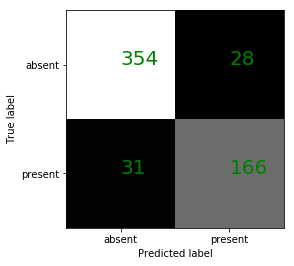

In [35]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(piece_test, pred_labels)
plot_cm(cm)

In [36]:
proba = clf.predict_proba(piece_features_scaled)
proba = proba[:,1]

In [37]:
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

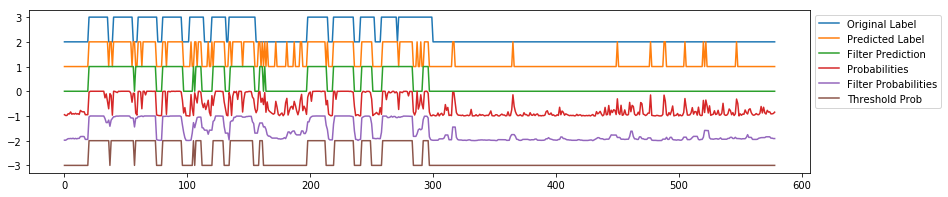

In [40]:
plt.figure(figsize=(14,3))
plt.plot(piece_test+2)
plt.plot(pred_labels+1)
plt.plot(scipy.signal.medfilt(pred_labels,kernel_size=5))
plt.plot(proba-1)
plt.plot(scipy.signal.medfilt(proba,kernel_size=5)-2)
thresh = np.zeros(len(proba))
thresh[scipy.signal.medfilt(proba,kernel_size=5) > 0.7] = 1
plt.plot(thresh-3)
plt.legend(['Original Label', 'Predicted Label', 'Filter Prediction', 
            'Probabilities', 'Filter Probabilities', 'Threshold Prob'], bbox_to_anchor=(1, 1))

### Perform Grid Search to find the best parameters

In [58]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.1]#gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [58]:
nfolds = 2
print (svc_param_selection(train_features_scaled, y_train, nfolds))

{'C': 10, 'gamma': 0.1}


In [ ]:
# Lets use a SVC with folowing C parameters: 
params = [10, 1, 0.1, 0.01, 0.001]

for c in params:
    clf1 = SVC(C=c)

    # Fit (=train) the model
    clf1.fit(train_features_scaled, y_train)
    
    # save the model to disk
    #filename = 'finalized_model_SVM_'+str(c)+'_VGGish.sav'
    #print (filename)
    #joblib.dump(clf, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf1.predict(test_features_scaled)
    # SVM Accuracy
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print(accuracy)
    
    # lets compute the show the confusion matrix:
    cm = sklearn.metrics.confusion_matrix(y_test, predictions)
    print(cm)
    
    plot_cm(cm)

### Random Forest Classifier without scaler

In [17]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

def rf_param_selection(X, y, nfolds):
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]# Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 100, cv = nfolds, verbose=2, random_state=42, 
                                   n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X, y)
    print (rf_random.best_params_)
    return rf_random.best_estimator_


In [18]:
nfolds = 2
best_rf = rf_param_selection(X_train, y_train, nfolds)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


{'n_estimators': 157, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [24]:
rf = RandomForestClassifier(n_estimators=157, min_samples_split=10, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=20, bootstrap=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=157,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
rf


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=157,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
# Now lets predict the labels of the test data!
predictions = rf.predict(X)

In [42]:
# Biased Guess Accuracy
ones = np.ones(len(predictions))
accuracy = sklearn.metrics.accuracy_score(y, ones)
print(accuracy)

0.6949274781633143


In [43]:
# SVM Accuracy
accuracy = sklearn.metrics.accuracy_score(y, predictions)
print(accuracy)

0.930322942543473


In [44]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(y, predictions)
print(cm)

[[ 6453  1161]
 [  578 16766]]


# Testing on one piece

In [66]:
piece_name = 'LizNelson_Rainfall'

In [67]:
vggish = pd.read_csv(VGGish_PATH+piece_name+"_VGGish_PCA.csv",index_col=None, header=None)
vggish = vggish.values

In [68]:
piece_features = vggish

In [69]:
pred_labels = rf.predict(piece_features)

In [70]:
piece_test = np.load(FEAT_PATH+piece_name+"_labels.npy")
print (piece_test.shape, vggish.shape)
piece_test = piece_test[:vggish.shape[0]]

(593,) (592, 128)


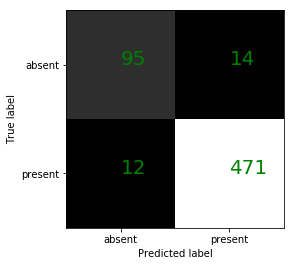

In [71]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(piece_test, pred_labels)
plot_cm(cm)

In [72]:
proba = rf.predict_proba(piece_features)
proba = proba[:,1]

In [73]:
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

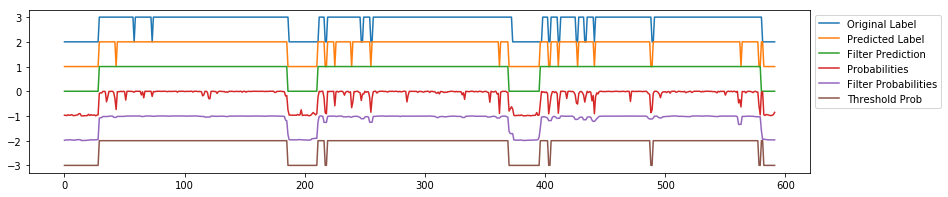

In [74]:
plt.figure(figsize=(14,3))
plt.plot(piece_test+2)
plt.plot(pred_labels+1)
plt.plot(scipy.signal.medfilt(pred_labels,kernel_size=5))
plt.plot(proba-1)
plt.plot(scipy.signal.medfilt(proba,kernel_size=5)-2)
thresh = np.zeros(len(proba))
thresh[scipy.signal.medfilt(proba,kernel_size=3) >= 0.5] = 1
plt.plot(thresh-3)
plt.legend(['Original Label', 'Predicted Label', 'Filter Prediction', 
            'Probabilities', 'Filter Probabilities', 'Threshold Prob'], bbox_to_anchor=(1, 1))

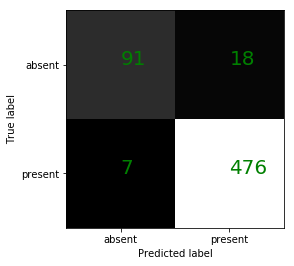

In [75]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(piece_test, thresh)
plot_cm(cm)

In [42]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.ensemble import RandomForestClassifier

results_rf = pd.DataFrame(columns=['classifier','parameter','accuracy', 'cm', 'features'])

classifier = 'RF'
features = 'VGGish'

for train_index, test_index in kf.split(X):


    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    params = [10, 20, 50, 100]

    for estimators in params:
        clf3 = RandomForestClassifier(n_estimators=estimators)

        # Fit (=train) the model
        clf3.fit(X_train, y_train)

        # save the model to disk
        #filename = 'finalized_model_RF_'+str(estimators)+'_'+features+'_'+str(n_split)+'.sav'
        #print (filename)
        #joblib.dump(clf3, filename)

        # Now lets predict the labels of the test data!
        predictions = clf3.predict(X_test)
        # We can use sklearn to compute the accuracy score
        accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
        print(accuracy)

        # lets compute the show the confusion matrix:
        cm = sklearn.metrics.confusion_matrix(y_test, predictions)
        print(cm)
        
        results_rf.loc[results_rf.index.max() + 1] = [classifier, estimators, accuracy, cm, features]

TRAIN: [13488 13489 13490 ... 26972 26973 26974] TEST: [    0     1     2 ... 13485 13486 13487]
0.828959074733096
[[3204 1000]
 [1307 7977]]
0.8385972716488731
[[3155 1049]
 [1128 8156]]
0.845344009489917
[[3133 1071]
 [1015 8269]]
0.8527580071174378
[[3179 1025]
 [ 961 8323]]
TRAIN: [    0     1     2 ... 13485 13486 13487] TEST: [13488 13489 13490 ... 26972 26973 26974]
0.8359902127975087
[[3053 1217]
 [ 995 8222]]
0.8425150144583673
[[2984 1286]
 [ 838 8379]]
0.8464447245495662
[[2972 1298]
 [ 773 8444]]
0.8492622525394825
[[2966 1304]
 [ 729 8488]]


In [43]:
results_rf

,classifier,parameter,accuracy,cm,features
NaN,RF,100,0.849262,"[[2966, 1304], [729, 8488]]",VGGish


In [44]:
results_rf.to_pickle('results_random_forest_m-v-f.pkl')

In [45]:
results_rf = pd.read_pickle('results_random_forest.pkl')
results_rf_3 = pd.read_pickle('results_random_forest_m-v-f.pkl')

In [46]:
results_rf

,classifier,parameter,accuracy,cm,features
0,RF,10,0.744083,"[[545, 573], [119, 1467]]",MFCC
1,RF,20,0.745192,"[[503, 615], [74, 1512]]",MFCC
2,RF,50,0.735207,"[[465, 653], [63, 1523]]",MFCC
3,RF,100,0.744453,"[[467, 651], [40, 1546]]",MFCC
4,RF,10,0.765533,"[[508, 490], [144, 1562]]",MFCC
5,RF,20,0.728920,"[[423, 575], [158, 1548]]",MFCC
6,RF,50,0.735577,"[[414, 584], [131, 1575]]",MFCC
7,RF,100,0.732618,"[[398, 600], [123, 1583]]",MFCC
8,RF,10,0.786243,"[[707, 166], [412, 1419]]",MFCC
9,RF,20,0.796598,"[[729, 144], [406, 1425]]",MFCC


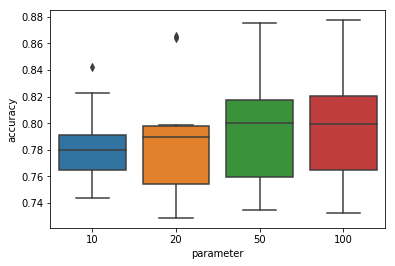

[(0.6, 1.0)]

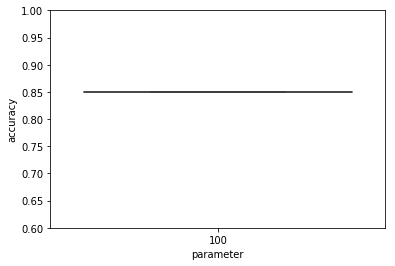

In [47]:
import seaborn as sns 
ax = sns.boxplot(x="parameter", y="accuracy", data=results_rf)
plt.show()
ax = sns.boxplot(x="parameter", y="accuracy", data=results_rf_3)
ax.set(ylim=(.60, 1.00))

0.7920828708842027
[[ 419  249]
 [ 313 1722]]


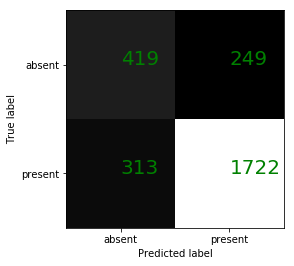

0.8079911209766926
[[ 416  252]
 [ 267 1768]]


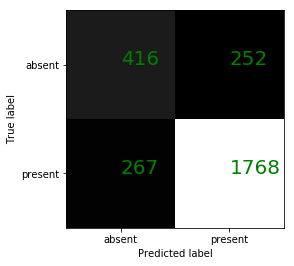

0.8161302256751757
[[ 395  273]
 [ 224 1811]]


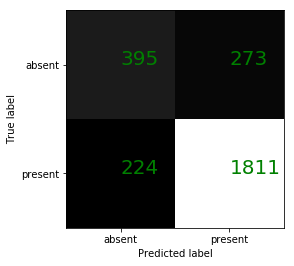

0.8205697373288938
[[ 394  274]
 [ 211 1824]]


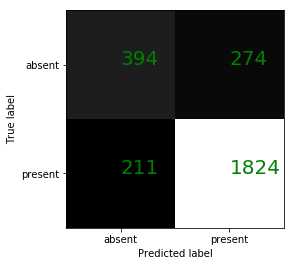

In [17]:
from sklearn.ensemble import RandomForestClassifier

params = [10, 20, 50, 100]

for estimators in params:
    clf3 = RandomForestClassifier(n_estimators=estimators)

    # Fit (=train) the model
    clf3.fit(X_train, y_train)
    
    # save the model to disk
    #filename = 'finalized_model_RF_'+str(estimators)+'_VGGish.sav'
    #print (filename)
    #joblib.dump(clf3, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf3.predict(X_test)
    # We can use sklearn to compute the accuracy score
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print(accuracy)
    
    # lets compute the show the confusion matrix:
    cm = sklearn.metrics.confusion_matrix(y_test, predictions)
    print(cm)
    
    plot_cm(cm)

In [48]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(X_test)

In [49]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

0.8492622525394825


In [50]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(y_test, predictions)
print(cm)

[[2966 1304]
 [ 729 8488]]


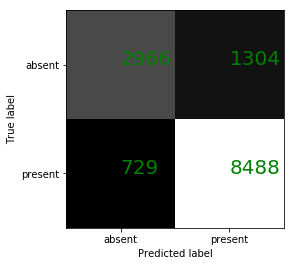

In [51]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

In [52]:
# Evaluate with Precision, Recall and F-score

In [53]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, predictions)


Text(0.5, 1.0, 'Singing Precision-Recall curve: AP=0.85')

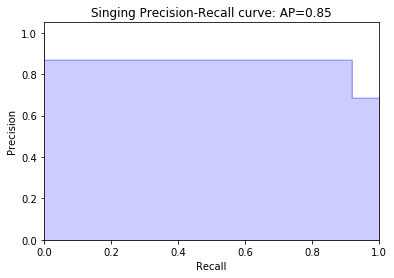

In [54]:
from inspect import signature
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Singing Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
